In [71]:
## References:

#https://www.kaggle.com/artgor/pytorch-whale-identifier
#https://www.kaggle.com/josephvm/kannada-pytorch-visualizations
#https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch
#https://www.kaggle.com/ateplyuk/aptos-pytorch-starter-rnet50

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
kaggle=1
if kaggle==0:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    for dirname,_,filenames in os.walk('C:/Users/deepa/Downloads/R/Kannada MNIST'):
        for filename in filenames:
            print(os.path.join(dirname,filename))

# Any results you write to the current directory are saved as output.

C:/Users/deepa/Downloads/R/Kannada MNIST\Dig-MNIST.csv
C:/Users/deepa/Downloads/R/Kannada MNIST\Kannada-MNIST.zip
C:/Users/deepa/Downloads/R/Kannada MNIST\sample_submission.csv
C:/Users/deepa/Downloads/R/Kannada MNIST\test.csv
C:/Users/deepa/Downloads/R/Kannada MNIST\train.csv
C:/Users/deepa/Downloads/R/Kannada MNIST\Yet Another MNIST !!!.ipynb
C:/Users/deepa/Downloads/R/Kannada MNIST\.ipynb_checkpoints\Yet Another MNIST !!!-checkpoint.ipynb


In [73]:
#!pip install albumentations > /dev/null 2>&1

In [2]:
###Import pytorch libraries utlis:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import tqdm
train_on_gpu=True

import cv2
import albumentations
from albumentations import pytorch as AT

In [3]:
## read the dataset:
if kaggle==0:
    train=pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
    test=pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
    sample_submission=pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
    digits=pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')
else:
    train=pd.read_csv('train.csv')
    test=pd.read_csv('test.csv')
    sample_submission=pd.read_csv('sample_submission.csv')
    digits=pd.read_csv('Dig-MNIST.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As per the dataset description , there is a additional dataset provided to us which we can use to validate our model before making the submission.We will use the `digits` dataset as the validation set.

In [6]:
print(f'There are {train.shape[0]} training examples')
print(f'There are {digits.shape[0]} validation examples')
print(f'There are {test.shape[0]} test examples')

There are 60000 training examples
There are 10240 validation examples
There are 5000 test examples


In [7]:
train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [80]:
digits['label'].value_counts()

7    1024
6    1024
5    1024
4    1024
3    1024
2    1024
9    1024
1    1024
8    1024
0    1024
Name: label, dtype: int64

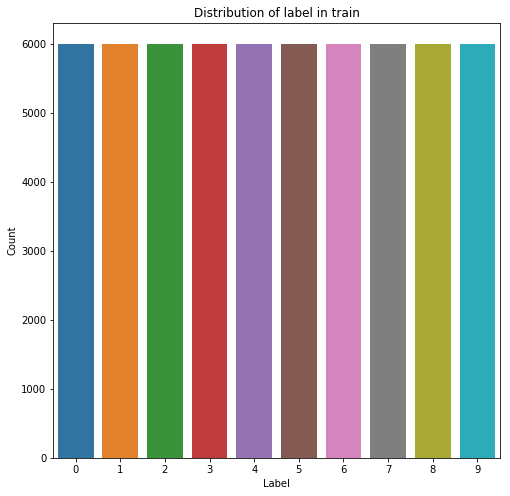

In [81]:
### distribution of class lables in train:

plt.figure(figsize=(8,8))
sns.countplot(train['label'])
plt.title("Distribution of label in train")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

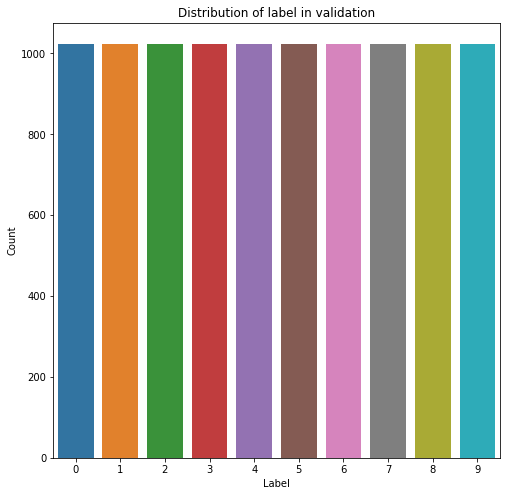

In [82]:
plt.figure(figsize=(8,8))
sns.countplot(digits['label'])
plt.title("Distribution of label in validation")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
## Transforms:

train_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# train_transform=albumentations.Compose([albumentations.Resize(224,224),albumentations.HorizontalFlip(),albumentations.RandomBrightness(),
#                                        albumentations.ShiftScaleRotate(rotate_limit=15,scale_limit=0.10),albumentations.JpegCompression(80),
#                                        albumentations.HueSaturationValue(),albumentations.Normalize(),AT.ToTensor()])
# test_transform=transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomRotation(0.3),
#     transforms.ToTensor()
# ])

In [42]:
class KannadaMNIST(Dataset):
    def __init__(self,images,data=None,transform=transforms.Compose([transforms.ToTensor()])):
        self.data=data
        self.images=images
        self.transform=transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,i):
        item=self.images.iloc[i]
        image=item[1:].values.astype(np.uint8).reshape(28,28,1)
        image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image=self.transform(image)
        if self.data is not None:
            label=item[0]
            return image,label
        else:
            return image

In [43]:
train_dataset=KannadaMNIST(train,'Train',transform=train_transform)
valid_dataset=KannadaMNIST(digits,'Valid',transform=test_transform)
test_dataset=KannadaMNIST(test,transform=test_transform)

In [44]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=True)

In [45]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(f'Batch Image shape {images.shape}')

print(images[1].numpy().transpose((1,2,0)).shape)
print(labels[1].item())

Batch Image shape torch.Size([32, 3, 28, 28])
(28, 28, 3)
0


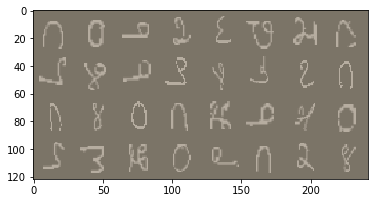

In [46]:
## Creating a simple nnet model:
##https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) ## changing the shape of the image.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
inputs,classes=next(iter(train_loader))
out=torchvision.utils.make_grid(inputs)

imshow(out)

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [90]:
# ### Building the model:

# class nnet(nn.Module):
#     def __init__(self):
#         super(nnet,self).__init__()
#         self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2) # (28,28,32)
#         self.conv1_bn=nn.BatchNorm2d(num_features=32) #
#         self.pool1=nn.MaxPool2d(kernel_size=2,stride=2) #(14,14,32)
        
#         self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2) # (14,14,64)
#         self.conv2_bn=nn.BatchNorm2d(num_features=64)
#         self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2) #(14,14,128)
#         self.pool2=nn.AvgPool2d(kernel_size=2,stride=2) # (7,7,128)
        
#         self.fc1=nn.Linear(in_features=7*7*128,out_features=1024)
#         self.fc1_batchnorm=nn.BatchNorm1d(num_features=1024)
#         self.dropout=nn.Dropout(0.5)
#         self.out=nn.Linear(in_features=1024,out_features=10)
        
#     def forward(self,x):
#         x=self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
#         x=self.pool2(F.relu(self.conv3(self.conv2_bn(self.conv2(x)))))
#         #print(x.shape)
#         x=x.view(-1,7*7*128)
#         x=F.relu(self.fc1_batchnorm(self.fc1(x)))
#         x=self.dropout(x)
#         x=self.out(x)
#         return(x)
        

In [35]:
model=torchvision.models.alexnet()

In [36]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [37]:
model.classifier[6]=nn.Linear(in_features=4096,out_features=10,bias=True)

In [38]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [39]:
# model=nnet().to(device)
model=model.to(device)

In [40]:

optimizer=optim.Adam(model.parameters(),lr=0.001)


In [41]:
n_epochs = 10
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []

    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

Mon Oct 28 11:14:50 2019 Epoch: 1


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small at c:\a\w\1\s\tmp_conda_3.7_110509\conda\conda-bld\pytorch_1544094576194\work\aten\src\thcunn\generic/SpatialDilatedMaxPooling.cu:53

In [94]:
#https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 10240 validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10240 validation images: 82.32421875 %


In [95]:
test_loader=DataLoader(test_dataset,shuffle=False)

In [96]:
predict = []
model.eval() ## weighted mean and variance will be used in batch norm for test
for i, (data) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy()    
    predict.append(output[0])

In [97]:
sample_submission.head()

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


In [98]:
sample_submission['label']=np.argmax(predict,axis=1)

In [99]:
sample_submission.to_csv('sample_submission.csv',index=False)